installing and importing various libraries

In [ ]:
%%capture
!pip install gymnasium[classic-control]
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

!pip install python-opengl
!pip install ffmpeg
!pip install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1
!pip install imageio-ffmpeg
!pip install pyyaml==6.0
!pip install git+https://github.com/ntasfi/PyGame-Learning-Environment.git
!pip install git+https://github.com/simoninithomas/gym-games
import imageio

## implementing replay buffer

ReplayBuffer is a class that has following important methods:
*   store: to store each experience we get by interacting with environment
*   sample: to choose a number of experiences randomly from stored experiences

In [ ]:
import numpy as np
import random

class ReplayBuffer:
    def __init__(self,replay_size,device):
        self.replay_size = replay_size
        self.device = device
        # self.states = []
        # self.actions = []
        # self.rewards = []
        # self.next_states = []
        # self.dones = []
        self.states = torch.tensor([]).to(device)
        self.actions = torch.tensor([]).to(device)
        self.rewards = torch.tensor([]).to(device)
        self.next_states = torch.tensor([]).to(device)
        self.dones = torch.tensor([]).to(device)

        self.idx = 0

    def store(self,state,action,next_state,reward,done):
        if len(self.states) < self.replay_size:

            self.states = torch.cat((self.states, torch.tensor([state]).to(device)),dim=0).to(device)
            self.actions = torch.cat((self.actions, torch.tensor([action]).to(device)),dim=0).to(device)
            self.next_states = torch.cat((self.next_states, torch.tensor([next_state]).to(device)),dim=0).to(device)
            self.rewards = torch.cat((self.rewards, torch.tensor([reward]).to(device)),dim=0).to(device)
            self.dones = torch.cat((self.dones, torch.tensor([done]).to(device)),dim=0).to(device)
            # print("states")
            # print(self.states)
            # print("state")
            # print(state)
            # print("actions")
            # print(self.actions)
            # print("action")
            # print(action)
            # print("rewards")
            # print(self.rewards)
            # print("reward")
            # print(reward)
            # print("dones")
            # print(self.dones)
            # print("done")
            # print(done)

            # self.next_states.append(next_state)
            # self.states.append(state)
            # self.actions.append(action)
            # self.rewards.append(reward)
            # self.dones.append(done)
        else:
            self.states[self.idx] = torch.tensor([state]).to(device)
            self.actions[self.idx] = torch.tensor([action]).to(device)
            self.rewards[self.idx] = torch.tensor([reward]).to(device)
            self.next_states[self.idx] = torch.tensor([next_state]).to(device)
            self.dones[self.idx] = torch.tensor([done]).to(device)
            # self.states[self.idx] = state
            # self.actions[self.idx] = action
            # self.rewards[self.idx] = reward
            # self.next_states[self.idx] = next_state
            # self.dones[self.idx] = done

        self.idx = (self.idx + 1) % self.replay_size

    def sample(self,batchsize,device):
        indicies_to_sample = random.sample(range(len(self.states)) , k=batchsize)

        # states = torch.from_numpy(np.array(self.states)[indicies_to_sample]).float().to(device)
        # actions = torch.from_numpy(np.array(self.actions)[indicies_to_sample]).float().to(device)
        # next_states = torch.from_numpy(np.array(self.next_states)[indicies_to_sample]).float().to(device)
        # rewards = torch.from_numpy(np.array(self.rewards)[indicies_to_sample]).float().to(device)
        # dones = torch.from_numpy(np.array(self.dones)[indicies_to_sample]).float().to(device)

        states = self.states[indicies_to_sample].float().to(device)
        actions = self.actions[indicies_to_sample].to(device)
        next_states = self.next_states[indicies_to_sample].float().to(device)
        rewards = self.rewards[indicies_to_sample].float().to(device)
        dones = self.dones[indicies_to_sample].to(device)

        return states , actions , next_states , rewards , dones

    def __len__(self):
        return len(self.states)

## implementing DQNetwork

DQNNetwork is a typical neural network class to implement a simple 3-layer mlp using pytorch

Agent is a class that contains all necessary methods to initialize, train, and use a DQN agent
it has following important methods:


*   update_target: it updates target network weights and set them equal to online network weights
*   select_action: action selection based on Q of online network and epsilon greedy strategy
*   update_epsilon: it updates epsilon after each episode using decaying method
*   learn: learning phase and computing loss and gradient is done here and after that it updates online weights
*   save and load: to save and load weights and biases for online network (we use for action selection)




In [ ]:
class DQNetwork(nn.Module):
    def __init__(self,state_size,action_size,lr):
        super(DQNetwork,self).__init__()
        self.L1 = nn.Linear(state_size,64)
        self.L2 = nn.Linear(64,64)
        self.L3 = nn.Linear(64,action_size)
        self.optimizer = optim.Adam(self.parameters(),lr=lr)

    def forward(self,x):
        x = self.L1(x)
        x = F.relu(x)
        x = self.L2(x)
        x = F.relu(x)
        x = self.L3(x)
        return x


class Agent:
    def __init__(self,obs_space,act_space,device,epsilon_max,epsilon_min,epsilon_decay,memory_capacity,discount=0.99,lr=1e-3):
        self.obs_space = obs_space
        self.act_space = act_space
        self.discount = discount
        self.device = device

        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max

        self.epsilon = self.epsilon_max

        self.rpb = ReplayBuffer(memory_capacity,device)

        self.online_network = DQNetwork(self.obs_space.shape[0],self.act_space.n,lr).to(self.device)
        self.target_network = DQNetwork(self.obs_space.shape[0],self.act_space.n,lr).to(self.device)

        self.target_network.eval()

        self.update_target()
    def update_target(self):
        self.target_network.load_state_dict(self.online_network.state_dict())


    def select_action(self,state):
        p = np.random.uniform()
        if p < self.epsilon:
            return self.act_space.sample()
        if not torch.is_tensor(state):
            state = torch.FloatTensor(state).to(self.device)

        with torch.no_grad():
            action = torch.argmax(self.online_network(state))
        return action.item()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def learn(self,batch_size):
        if len(self.rpb) < batch_size:
            return
        states , actions , next_states , rewards , dones = self.rpb.sample(batch_size,self.device)
        actions = actions.reshape((-1,1))
        rewards = rewards.reshape((-1,1))
        dones = dones.reshape((-1,1))

        predicted_qs = self.online_network(states)
        actions_int64 = actions.to(torch.int64)
        predicted_qs = predicted_qs.gather(1,actions_int64)

        target_qs = self.target_network(next_states)
        target_qs = torch.max(target_qs,dim=1).values
        target_qs = target_qs.reshape(-1,1)
        dones_int64 = dones.to(torch.int64)
        target_qs[dones_int64] = 0.0
        y_js = rewards + (self.discount * target_qs)

        loss = F.mse_loss(predicted_qs,y_js)
        self.online_network.optimizer.zero_grad()
        loss.backward()
        self.online_network.optimizer.step()

    def save(self,filename):
        torch.save(self.online_network.state_dict(),filename)

    def load(self,filename):
        # self.online_network.load_state_dict(torch.load(filename , map_location=torch.device('cpu')))
        self.online_network.load_state_dict(torch.load(filename , map_location=self.device))
        self.online_network.eval()

## Some high level functions

these methods are implemented to facilitate the coding and plotting results. each method is described in below:
*   get_expected_reward: it computes expected rewards from training N times to compute statistical results and 95% bound
*   record_video: it records the video of environment and store it. it is used after the training phase and stores the performance of agent visually
*   fill_memory: this special method is used before training and it makes agent interact with the environment and gather experience and filling up replay buffer before trying to learn. it takes total number of episodes for filling the buffer as input
*   train: env-agent interaction cycle for a number of episodes is implemented in order to train agent and after each episode, it prints out some detail about training and scores. it also saves the best model weights
*   test:  env-agent interaction cycle for a number of episodes is implemented in order to test the agent by changing epsilon=0 and printing out the episodic reward


In [ ]:
import os

# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

def get_exp_reward(filename):
    dic = load_var(filename)
    reward_store = dic["reward_store"]
    reward_store = np.array(reward_store)
    mean = np.mean(reward_store,axis=0).reshape((-1,))
    std = np.std(reward_store,axis=0).reshape((-1,))
    return mean,std

def record_video(env, agent, out_directory, fps=30):
    images = []
    state , info = env.reset()
    done = False
    img = env.render()
    images.append(img)
    while not done:
        action = agent.select_action(state)
        state , reward , terminated , truncated ,info = env.step(action)
        done = truncated or terminated
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory + '.mp4', [np.array(img) for i, img in enumerate(images)], fps=fps)

def fill_memory(env,agent,memory_fill_eps):
    for _ in range(memory_fill_eps):
        state , info = env.reset()
        done = False
        while not done:
            action = agent.select_action(state)
            next_state , reward , terminated , truncated ,info = env.step(action)
            done = truncated or terminated
            agent.rpb.store(state,action,next_state,reward,done)
            state = next_state


def train(env,agent,train_eps,memory_fill_eps,batchsize,update_freq , model_filename):
    fill_memory(env,agent,memory_fill_eps)
    print("Samples in memory: " , len(agent.rpb))

    step_cnt = 0
    reward_history = []
    best_score = -np.inf
    for eps_cnt in range(train_eps):
        state ,info = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action = agent.select_action(state)
            next_state , reward , terminated , truncated ,info = env.step(action)
            done = truncated or terminated
            agent.rpb.store(state,action,next_state,reward,done)
            agent.learn(batchsize)

            if step_cnt % update_freq == 0:
                agent.update_target()

            state = next_state
            ep_reward += reward
            step_cnt += 1
        agent.update_epsilon()
        reward_history.append(ep_reward)

        current_ave_score = np.mean(reward_history[-30:])
        print(f'Ep: {eps_cnt}, Total_steps: {step_cnt}, Ep score: {ep_reward}, avg score: {current_ave_score}, updated epsilon: {agent.epsilon}')

        if current_ave_score >= best_score:
            agent.save(model_filename)
            best_score = current_ave_score
    return reward_history,best_score

def test(env,agent,test_eps):
    eps = agent.epsilon
    agent.epsilon = 0
    for ep_cnt in range(test_eps):
        state , info = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action = agent.select_action(state)
            state , reward , terminated , truncated ,info = env.step(action)
            done = truncated or terminated
            ep_reward += reward
        print(f'Ep: {ep_cnt}, Ep score: {ep_reward}')
    agent.epsilon = eps
def set_seed(env,seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    env.action_space.seed(seed_value)

def get_device():
    # Check if GPU is available
    device = None
    if torch.cuda.is_available():
        device = torch.device("cuda:0") # Use the first available GPU
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")
    return device

loading and saving functions

In [ ]:
import pickle
def load_var(file_path):
    loaded_data = None
    with open(file_path, 'rb') as file:
        # Deserialize and retrieve the variable from the file
        loaded_data = pickle.load(file)
    return loaded_data

def save_var(file_path,data):
    with open(file_path, 'wb') as file:
        # Serialize and write the variable to the file
        pickle.dump(data, file)

In [ ]:
device = get_device()
path = "/content/"
train_mode = True
env = gym.make('Acrobot-v1',render_mode = "rgb_array")

In [ ]:
from tqdm import tqdm
seed_num = 0
training_episodes = 600
memory_fill_eps = 0
epsilon_max = 1
epsilon_min = 0.1
epsilon_decay = 0.97
memory_capacity = 10000
discount = 0.99
lr = 0.001
batchsize = 1024
update_freq = 100

##
N_stat = 10

filename = f"-eps_decay {epsilon_decay}-mem_cap {memory_capacity}-batchsize {batchsize}-update_freq {update_freq}"

set_seed(env,seed_num)
env.reset(seed=seed_num)

agent = Agent(env.observation_space,env.action_space,device,epsilon_max,epsilon_min,epsilon_decay,memory_capacity,discount,lr)


if train_mode:
    reward_store = []
    best_score_store = []
    for stat_idx in tqdm(range(N_stat)):
        reward_history,best_score = train(env, agent, training_episodes, memory_fill_eps,batchsize,update_freq,
                                        model_filename= path + "weights" + filename)
        reward_store.append(reward_history)
        best_score_store.append(best_score)
        agent = Agent(env.observation_space,env.action_space,device,epsilon_max,epsilon_min,epsilon_decay,memory_capacity,discount,lr)
        env.reset()
    save_var(path + "result" + filename,{"reward_store":reward_store,"best_score_store":best_score_store})

    # setting train mode to False in order to get evaluation and statistical results
    train_mode = False


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-2-910e2a9253dd>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  self.states = torch.cat((self.states, torch.tensor([state]).to(device)),dim=0).to(device)


Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 3000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 4000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4340, Ep score: -339.0, avg score: -482.1111111111111, updated epsilon: 0.7602310586545651
Ep: 9, Total_steps: 4785, Ep score: -444.0, avg score: -478.3, updated epsilon: 0.7374241268949281
Ep: 10, Total_

 10%|█         | 1/10 [06:20<57:03, 380.42s/it]

Ep: 599, Total_steps: 79369, Ep score: -91.0, avg score: -124.0, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 318, Ep score: -317.0, avg score: -317.0, updated epsilon: 0.97
Ep: 1, Total_steps: 818, Ep score: -500.0, avg score: -408.5, updated epsilon: 0.9409
Ep: 2, Total_steps: 1318, Ep score: -500.0, avg score: -439.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 1818, Ep score: -500.0, avg score: -454.25, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2318, Ep score: -500.0, avg score: -463.4, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 2818, Ep score: -500.0, avg score: -469.5, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3260, Ep score: -441.0, avg score: -465.42857142857144, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3644, Ep score: -383.0, avg score: -455.125, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 3992, Ep score: -347.0, avg score: -443.1111111111111, updated epsilon: 0.7602310586545651
Ep: 9, Total

 20%|██        | 2/10 [11:56<47:13, 354.14s/it]

Ep: 599, Total_steps: 71848, Ep score: -129.0, avg score: -114.7, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2433, Ep score: -432.0, avg score: -486.4, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 2933, Ep score: -500.0, avg score: -488.6666666666667, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3433, Ep score: -500.0, avg score: -490.2857142857143, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3779, Ep score: -345.0, avg score: -472.125, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4278, Ep score: -498.0, avg score: -475.0, updated epsilon: 0.7602310586545651
Ep: 9, Total

 30%|███       | 3/10 [18:05<42:06, 360.98s/it]

Ep: 599, Total_steps: 78513, Ep score: -87.0, avg score: -112.13333333333334, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 3000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 4000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.7602310586545651
Ep: 9, Total_steps: 4897, 

 40%|████      | 4/10 [25:01<38:17, 382.85s/it]

Ep: 599, Total_steps: 88176, Ep score: -88.0, avg score: -103.26666666666667, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 2966, Ep score: -465.0, avg score: -494.1666666666667, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3396, Ep score: -429.0, avg score: -484.85714285714283, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3896, Ep score: -500.0, avg score: -486.75, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4250, Ep score: -353.0, avg score: -471.8888888888889, updated epsilon: 0.76023

 50%|█████     | 5/10 [31:36<32:16, 387.24s/it]

Ep: 599, Total_steps: 82618, Ep score: -96.0, avg score: -109.93333333333334, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 3000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3491, Ep score: -490.0, avg score: -498.57142857142856, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3991, Ep score: -500.0, avg score: -498.75, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4491, Ep score: -500.0, avg score: -498.8888888888889, updated epsilon: 0.7602310586545651


 60%|██████    | 6/10 [38:32<26:28, 397.02s/it]

Ep: 599, Total_steps: 72290, Ep score: -114.0, avg score: -97.1, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 3000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 4000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4456, Ep score: -455.0, avg score: -495.0, updated epsilon: 0.7602310586545651
Ep: 9, Total_steps: 4956, Ep score: -50

 70%|███████   | 7/10 [45:02<19:44, 394.78s/it]

Ep: 599, Total_steps: 74345, Ep score: -79.0, avg score: -109.1, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 935, Ep score: -434.0, avg score: -467.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1435, Ep score: -500.0, avg score: -478.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 1935, Ep score: -500.0, avg score: -483.5, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2435, Ep score: -500.0, avg score: -486.8, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 2935, Ep score: -500.0, avg score: -489.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3283, Ep score: -347.0, avg score: -468.7142857142857, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3750, Ep score: -466.0, avg score: -468.375, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4250, Ep score: -500.0, avg score: -471.8888888888889, updated epsilon: 0.7602310586545651
Ep: 9, Total_s

 80%|████████  | 8/10 [53:35<14:24, 432.37s/it]

Ep: 599, Total_steps: 84934, Ep score: -87.0, avg score: -128.06666666666666, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 2947, Ep score: -446.0, avg score: -491.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3447, Ep score: -500.0, avg score: -492.2857142857143, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3947, Ep score: -500.0, avg score: -493.25, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4314, Ep score: -366.0, avg score: -479.1111111111111, updated epsilon: 0.7602310586545651
E

 90%|█████████ | 9/10 [1:00:13<07:01, 421.54s/it]

Ep: 599, Total_steps: 71333, Ep score: -86.0, avg score: -89.23333333333333, updated epsilon: 0.1
Samples in memory:  0
Ep: 0, Total_steps: 500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.97
Ep: 1, Total_steps: 1000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.9409
Ep: 2, Total_steps: 1500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.912673
Ep: 3, Total_steps: 2000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8852928099999999
Ep: 4, Total_steps: 2500, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8587340256999999
Ep: 5, Total_steps: 3000, Ep score: -500.0, avg score: -500.0, updated epsilon: 0.8329720049289999
Ep: 6, Total_steps: 3348, Ep score: -347.0, avg score: -478.14285714285717, updated epsilon: 0.8079828447811299
Ep: 7, Total_steps: 3848, Ep score: -500.0, avg score: -480.875, updated epsilon: 0.783743359437696
Ep: 8, Total_steps: 4348, Ep score: -500.0, avg score: -483.0, updated epsilon: 0.7602310586545651
Ep: 9, Total

100%|██████████| 10/10 [1:06:15<00:00, 397.58s/it]

Ep: 599, Total_steps: 68351, Ep score: -78.0, avg score: -97.2, updated epsilon: 0.1


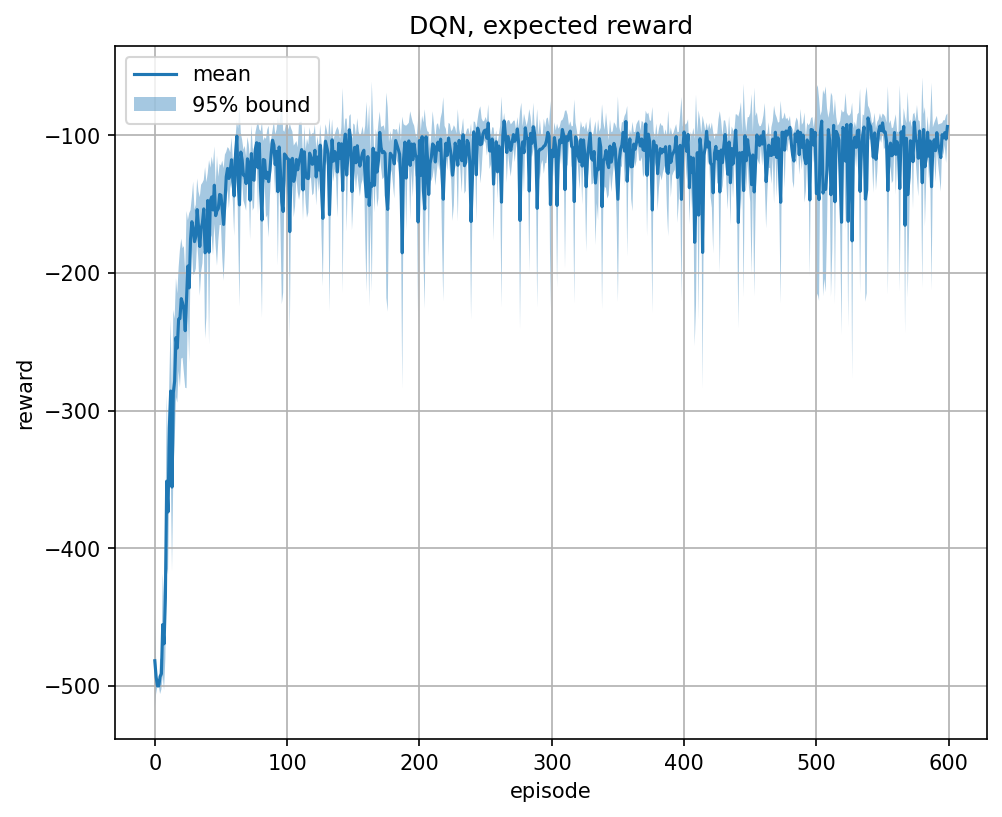

In [ ]:
import matplotlib.pyplot as plt
if train_mode  == False:
    # making video
    agent.load(path + "weights" + filename)
    agent.epsilon = 0
    # making plots
    mean_exp, std_exp = get_exp_reward(path + "result" + filename)
    x = np.arange(training_episodes)
    plt.figure(figsize=(7.5,6),dpi=150)
    plt.plot(mean_exp,label="mean")

    plt.fill_between( x, mean_exp - 1.96*std_exp/np.sqrt(N_stat), mean_exp + 1.96*std_exp/np.sqrt(N_stat), alpha=0.4, label="95% bound")
    plt.grid(True)
    plt.title("DQN, expected reward")
    plt.legend()
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.show()




## recording video

In [ ]:
from IPython.display import Video , display
agent.epsilon = 0
for i in range(5):
    video_path = 'agent_video ' + str(i)
    record_video(env, agent, video_path, 30)

# Video('/content/'+video_path +'.mp4', embed=True)

In [ ]:
for i in range(5):
    video_path = 'agent_video ' + str(i)
    display(Video('/content/'+video_path +'.mp4', embed=True))
    # display()